In [6]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit,transpile, QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit_aer import AerSimulator
from qiskit import BasicAer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")

# Invoke a primitive inside a session. For more details see https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials.html
# with Session(backend=service.backend("ibmq_qasm_simulator")):
#     result = Sampler().run(circuits).result()

# Iterative throw/days simulation 

In [7]:
###### Estimting number of Qubits required ###########

N = 5  # number of balls and number of buckets 
n = len(format(N-1,'b')) # number of qubits per ball/bucket

print(N*n,"qubits required")

15 qubits required


In [8]:
########## Building the KPR Problem Circuit #############

qreg = QuantumRegister(N*n)
circuit = QuantumCircuit(qreg)


circuit.h(range(len(qreg)))
circuit.measure_all()
# circuit.draw('mpl')

In [9]:
d = 100 # number of throws/days (iterative)
utility = []

###################################
buckets = np.arange(2**n)
unused_buckets = list((buckets[buckets > (N-1)]).astype(str))
###################################


for _ in range(d):
    backend = BasicAer.get_backend('qasm_simulator') # the device to run on
    result = backend.run(transpile(circuit, backend), shots=1).result()
    counts = result.get_counts()
    state  = list(counts.keys())[0] # getting the quantum state
    
    
    ##################  Converting the result into bucket/restaurant number  #################
    config = [str(int(state[i:i+n],2)) for i in range(0,len(state),n)]
    key = "".join([str(item) for item in config]) # converted into ball number

    ##################  Removing outputs with unused buckets  ##############################
    if not any([x in key for x in unused_buckets]):
        ######### postprocessing: replacing buckets by X if a ball is already present there (starting from left)
        
        t = [i for i in key]
        counter = dict(Counter(key))
        uniques = list(counter.keys())
        k_array = np.array([int(i) for i in key])

        for u in uniques:
            locations = np.where(k_array == int(u))
            indices = locations[0][1:]
            if len(indices) >= 1:
                for j in indices:
                    t[j] = 'X'
                    # print('Replacing {} with X for {}'.format(j,u))
            else:
                pass
        final_config = ''.join(t)
        
        ########### occupancy calculation #############
        occupancy = ((len(final_config) - final_config.count('X'))/len(final_config))
        utility.append(occupancy)
        print("Throws/day number {}:|{}> --> {} --> {} with occupancy:{}%".format(_+1,state,key,final_config,occupancy*100))
    else:
        # print(key,'is an invalid cofiguration')
        pass
        
        
    
    # print("Throws/day number {}:{} --> {}".format(_+1,state,key))

Throws/day number 2:|000100011010010> --> 04322 --> 0432X with occupancy:80.0%
Throws/day number 12:|010011001011100> --> 23134 --> 231X4 with occupancy:80.0%
Throws/day number 14:|100100011001100> --> 44314 --> 4X31X with occupancy:60.0%
Throws/day number 17:|100001001011100> --> 41134 --> 41X3X with occupancy:60.0%
Throws/day number 33:|011011000001011> --> 33013 --> 3X01X with occupancy:60.0%
Throws/day number 43:|100000000011000> --> 40030 --> 40X3X with occupancy:60.0%
Throws/day number 55:|100011100010000> --> 43420 --> 43X20 with occupancy:80.0%
Throws/day number 57:|100100000010010> --> 44022 --> 4X02X with occupancy:60.0%
Throws/day number 60:|001000001010001> --> 10121 --> 10X2X with occupancy:60.0%
Throws/day number 77:|010001011010100> --> 21324 --> 213X4 with occupancy:80.0%
Throws/day number 81:|011001001011011> --> 31133 --> 31XXX with occupancy:40.0%
Throws/day number 91:|000011011010010> --> 03322 --> 03X2X with occupancy:60.0%
Throws/day number 92:|011100010001010> --

Quantum: The average occupancy or utility is 66.15384615384615% for 5 balls and 5 buckets


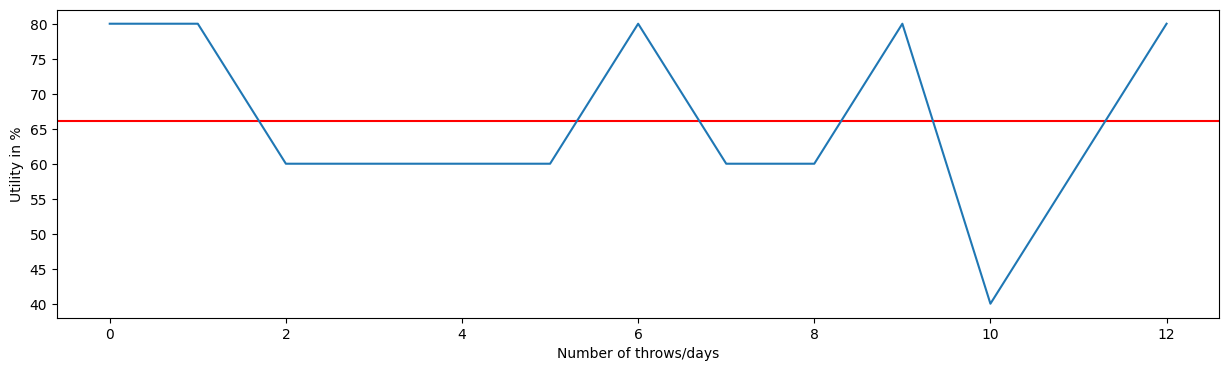

In [10]:
print("Quantum: The average occupancy or utility is {}% for {} balls and {} buckets".format(np.array(utility).mean()*100,N,N))


plt.figure(figsize=(15,4))
plt.ylabel("Utility in %")
plt.xlabel("Number of throws/days")
plt.axhline(y = np.array(utility).mean()*100, color = 'r', linestyle = '-')
plt.plot(np.array(utility)*100)
plt.show()